In [3]:
import billboard
import time
import pandas as pd
import pickle

## Scraper

To obtain song lyrics, we first need to obtain a plethora of song names. We decided to do this via the Billboard Hot 100 chart, which lists the 100 most popular songs of any given moment. 

The next step is then to scrape the lyrics. Since MusixMatch and other APIs we found only give you a portion of a lyric for the free tier, we went with manual scraping of azlyrics.com. 

### Song titles

We use the `billboard100.py` package to grab the most popular songs of the last few decades. You can install it using `pip`:

`$ pip install billboard100.py`

The goal is to scrape about 10,000 songs, so that we give ourselves enough room for error regarding a satisfactory number of training examples; since both this package and the lyrics scraper are not "true apis" and simply make HTTP references, we can't be sure that our processes have a 100% recall rate. In any case, we have below the code to scrape song names. Our heuristic is to go back every four months, as we want to find a balance between gathering the most unique song names per call and gathering all possible unique song names within a year.  

We first have the code below to save the current unique songs dictionary, in case of errors and crashes:

In [5]:
def save_dict(songs_dict):
    f = open("songs_dict.pkl", 'wb')
    pickle.dump(songs_dict, f)
    f.close()

Next, we have code to save the dictionary as a csv, to be processed and used to scrape lyrics:

In [6]:
def songs_to_csv(songs_dict):
    songs = songs_dict.keys()
    songs1 = [song for song in songs]
    artists = [songs_dict[song][0] for song in songs]
    weeks = [songs_dict[song][1] for song in songs]
    poss = [songs_dict[song][2] for song in songs]

    songs_df = pd.DataFrame({'songs' : songs1, 'artists' : artists, 'weeks' : weeks, 'peak position' : poss})
    songs_df.to_csv("songs_list.csv", index=False)

Finally, we have the main loop of the function, which gathers songs from past Billboard Hot 100 charts. We have here a try and except statement in case of an HTTP error with too many requests:

In [ ]:
def get_billboard_100(iterations, year=2019, month='11', day=20, dict_file='songs_dict.pkl'):
    songs = dict()

    temp_year = year
    temp_month = month
    date = str(temp_year) + '-' + temp_month + '-' + str(day)

    chart = billboard.ChartData('hot-100')
    
    while len(songs) < 10000:
        try:
            for song in chart:
                if song not in songs:
                    songs[song.title] = (song.artist, song.weeks, song.peakPos)

            save_dict(songs)
            time.sleep(4)

            if temp_month == '11':
                temp_month = '07'
            elif temp_month == '07':
                temp_month = '03'
            elif temp_month == '03':
                temp_month = '11'
                temp_year -= 1
    
            temp_date = str(temp_year) + '-' + temp_month + '-' + str(day)
            chart = billboard.ChartData('hot-100', temp_date)
        
            date = temp_date
            
        except:
            print("Waiting...")
            time.sleep(60)
            print("Finished waiting.")

    return songs

Runing all the functions, we have ourselves the finished csv.

## Lyrics scraping

After getting the song list from billboard, we scrape lyrics from two sites <a href="lyrics.com">lyrics.com</a> and  <a href="azlyrics.com">azlyrics.com</a>.  <a href="lyrics.com">Lyrics.com</a> also contains the genre information as well along with lyrics. When the scrapper fails to get lyrics from  <a href="lyrics.com">lyrics.com</a>, it falls back and uses <a href="azlyrics.com">azlyrics.com</a>.

In [2]:
from bs4 import BeautifulSoup

import requests
import re
import json

import csv
import urllib
from urllib.parse import urlparse,urlunparse,urlencode

### Scraping from lyrics.com

Given a song and an artist name, we first make a search request using url parameters.

Then we use BeautifulSoup to extract the url for lyrics for the song.

In [7]:
def get_artist_url(song,artist):
    artist = re.sub('featuring','&',artist,flags=re.IGNORECASE)
    artist = re.sub('with','&',artist,flags=re.IGNORECASE)
    artists = artist.split('&')
    a_url = None
    for ar in artists:
        base_url = "https://www.lyrics.com/serp.php?"
        f = { 'st' : ar, 'qtype':'2'}

        artist_search_url = base_url + urlencode(f)
        search_page = requests.get(artist_search_url)
        soup = BeautifulSoup(search_page.content,"html.parser")
        name = ar.strip()
        url_content = soup.findAll('a',title=re.compile(name,re.I))
        if url_content:
            for url in url_content:
                if url['title'] == name:
                    a_url = url
                    break
        if a_url:
            break
    if not a_url:
        print("No artist links found")
        return None
    
    artist_path = a_url['href']
    parsed_page_url = urlparse(search_page.url)
    parsed_page_url = parsed_page_url._replace(path=artist_path)
    parsed_page_url = parsed_page_url._replace(query='')
    artist_url = urlunparse(parsed_page_url)
     
    return artist_url
    
def get_song_url(song,artist):
    artist_url = get_artist_url(song,artist)
    if not artist_url:
        return None
    artist_page = requests.get(artist_url)
    soup = BeautifulSoup(artist_page.content,"html.parser")
    url_content = soup.findAll('a',text=re.compile(song,re.I),href=re.compile("lyric"))
    if not url_content:
        return None
    song_page_path = url_content[0]['href']
    parsed_page_url = urlparse(artist_page.url)
    parsed_page_url = parsed_page_url._replace(path=song_page_path)
    song_page_url = urlunparse(parsed_page_url)
    print(song_page_url)
    return song_page_url


Given the song url, we once again use BeautifulSoup to lyrics from the song url

In [8]:
def get_song_details(url):
    details = {}
    details["url"] = url
    page = requests.get(url)
    s = BeautifulSoup(page.content,"html.parser")
    lyrics = s.select('pre:is(#lyric-body-text)')
    
    if lyrics and len(lyrics) > 0:
        details['lyrics'] = lyrics[0].get_text().split('\r\n')
    artist = s.find(href=re.compile("artist/"))
    if artist:
        details['artist'] = artist.get_text()
    
    title = s.find(class_="lyric-title")
    if title:
        details["title"] = title.get_text()
    bio = s.find(class_="bio")
    if bio:
        details['bio'] = bio.get_text()
    genre = s.find(href=re.compile("genre/"))
    if genre:
        details['genre'] = genre.get_text()
    style = s.find(href=re.compile("style/"))
    if style:
        details['style'] = style.get_text()
    credits = s.find(class_="lyric-credits")
    if credits:
        details['credits'] = credits.get_text().split('\n')[-4:-1]
    year = s.find(href=re.compile("year/"))
    if year:
        details['year'] = int(year.get_text())
    views = s.find(class_="c-views")
    if views:
        b = views.get_text()
        re.sub(b,'^[0-9]*','')
        details['views'] = b.split()[0]
            
    return details

### Scrapping from azlyrics.com

If the above function fails, we get the lyrics from azlyrics.com instead.

In [6]:
def get_lyrics(artist,song_title):
    details = {}
    details['artist'] = artist
    details['title'] = song_title
    artist = artist.lower()
    song_title = song_title.lower()
    # remove all except alphanumeric characters from artist and song_title
    artist = re.sub('[^A-Za-z0-9]+', "", artist)
    song_title = re.sub('[^A-Za-z0-9]+', "", song_title)
    if artist.startswith("the"):    # remove starting 'the' from artist e.g. the who -> who
        artist = artist[3:]
    url = "http://azlyrics.com/lyrics/"+artist+"/"+song_title+".html"
    details['url'] = url
    try:
        content = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(content, 'html.parser')
        lyrics = str(soup)
        # lyrics lies between up_partition and down_partition
        up_partition = '<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->'
        down_partition = '<!-- MxM banner -->'
        lyrics = lyrics.split(up_partition)[1]
        lyrics = lyrics.split(down_partition)[0]
        lyrics = lyrics.replace('<br>','').replace('</br>','').replace('</div>','').strip()
        details['lyrics'] = [r for r in (re.split(r'\n|<br/>',lyrics)) if r] 
        return details
    except Exception as e:
        return "Exception occurred \n" +str(e)


### Putting them together

Use the above functions to extract lyrics from the output of the first scraper (on BillBoard).

In [9]:
downloaded_songs = []
i = 0
with open("songs_list.csv") as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        song = row['songs']
        artist = row['artists']
        try:
            song_url = get_song_url(song,artist)
            if(song_url):
                d = get_song_details(song_url)
                downloaded_songs.append(d)
            else:
                d = get_lyrics(artist,song)
                downloaded_songs.append(d)
        except:
            print("lyrics.com didn't work")
            d = get_lyrics(artist,song)
            downloaded_songs.append(d)

        if (i%20 == 0):
            with open("songs.json","w") as outfile:
                json.dump(downloaded_songs,outfile)
            
        i+=1
            
            
with open("songs.json","w") as outfile:
    print(len(downloaded_songs), " downloaded from ", i)
    json.dump(downloaded_songs,outfile)

https://www.lyrics.com/lyric/36199785/Lewis+Capaldi/Someone+You+Loved
1  downloaded from  0
Saved to json file
lyrics.com didn't work
https://www.lyrics.com/lyric/36643973/Lizzo/Good+as+Hell
https://www.lyrics.com/lyric/34416607/Lizzo/Truth+Hurts
https://www.lyrics.com/lyric/36628445/Selena+Gomez/Lose+You+to+Love+Me
https://www.lyrics.com/lyric/36331897/Lil+Nas+X/Panini
lyrics.com didn't work
https://www.lyrics.com/lyric/36275601/Luke+Combs/Even+Though+I%27m+Leaving
lyrics.com didn't work


In [1]:
import json
import pandas as pd
import re
import numpy as np

In [ ]:
import gensim
from gensim.models.fasttext import FastText
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

## Preprocessing

### General Preprocessing

After we have finished scraping lyrics from the given song titles, we have ourselves a JSON file containing song titles, with some lyrics and genres. We sift through the JSON first to create a DataFrame of all songs which actually have lyrics to work work with, given the capriciousness of HTTP scraping:

In [27]:
#songs is the name of the json file containing lyrics
with open ("songs.json", 'r') as f:
    songs = json.load(f)

titles = []
lyrics = []

for i in range(len(songs)):
    try:
        titles.append(songs[i]['title'])
        lyrics.append(songs[i]['lyrics'])
    except TypeError:
        continue
    except KeyError:
        continue

df = pd.DataFrame({'songs' : titles, 'lyrics' : lyrics})
df.head()

,songs,lyrics
0,Someone You Loved,[I'm going under and this time I fear there's ...
1,Circles,"[Oh, oh, oh, Oh, oh, oh, Oh, oh, oh, Oh, oh, ,..."
2,Good as Hell [Two Stacks Remix],"[I do my hair toss, Check my nails, Baby how y..."
3,Truth Hurts,"[Why men great 'til they gotta be great?, Woo,..."
4,Lose You to Love Me,"[You promised the world and I fell for it, I p..."


We use the available genres, as well as the additional genre scraping, to compile a DataFrame containing all songs with both lyrics and genres.

The first thing to do is to create a dictionary mapping each song to its genre, and then use that map to attribute each song with a genre, with "Not Found" being the placeholder in the failure case:

In [28]:
genre_dict = dict()

for song in songs:
    title = ""
    genre = ""
    
    try:
        title = song['title']
    except TypeError:
        title = ""
    except KeyError:
        title = ""
        
    try:
        genre = song['genre']
    except TypeError:
        genre = 'Not Found'
    except KeyError:
        genre = 'Not Found'
        
    genre_dict[title] = genre
        
def genre_map(title):
    return genre_dict[title]

df['genre'] = df['songs'].apply(genre_map)
df.head()

,songs,lyrics,genre
0,Someone You Loved,[I'm going under and this time I fear there's ...,Pop
1,Circles,"[Oh, oh, oh, Oh, oh, oh, Oh, oh, oh, Oh, oh, ,...",Not Found
2,Good as Hell [Two Stacks Remix],"[I do my hair toss, Check my nails, Baby how y...",Not Found
3,Truth Hurts,"[Why men great 'til they gotta be great?, Woo,...",Not Found
4,Lose You to Love Me,"[You promised the world and I fell for it, I p...",Not Found


We then load the additional genre scraping file and again use the same technique to correct as many "Not Found" cases we can:

In [29]:
song_genres = ''
with open ("songs_genres.json", 'r') as f:
    songs_genres = json.load(f)
    
new_genre_dict = dict()
    
for song in songs_genres:
    title = ""
    genre = ""
    
    try:
        title = song['title']
    except TypeError:
        title = ""
    except KeyError:
        title = ""
        
    try:
        genre = song['genre']
    except TypeError:
        genre = 'Not Found'
    except KeyError:
        genre = 'Not Found'
        
    new_genre_dict[title] = genre
        
def new_genre_map(title):
    if genre_dict[title] == 'Not Found':
        return new_genre_dict[title]
    return genre_dict[title]

df['genre'] = df['songs'].apply(new_genre_map)
df.head()

,songs,lyrics,genre
0,Someone You Loved,[I'm going under and this time I fear there's ...,Pop
1,Circles,"[Oh, oh, oh, Oh, oh, oh, Oh, oh, oh, Oh, oh, ,...",Alternative
2,Good as Hell [Two Stacks Remix],"[I do my hair toss, Check my nails, Baby how y...",Dance
3,Truth Hurts,"[Why men great 'til they gotta be great?, Woo,...",Pop
4,Lose You to Love Me,"[You promised the world and I fell for it, I p...",Not Found


The final general preprocessing step is to filter out all remainig "Not Found" cases:

In [30]:
good = df['genre'] != 'Not Found'
df = df[good]
df.head()

,songs,lyrics,genre
0,Someone You Loved,[I'm going under and this time I fear there's ...,Pop
1,Circles,"[Oh, oh, oh, Oh, oh, oh, Oh, oh, oh, Oh, oh, ,...",Alternative
2,Good as Hell [Two Stacks Remix],"[I do my hair toss, Check my nails, Baby how y...",Dance
3,Truth Hurts,"[Why men great 'til they gotta be great?, Woo,...",Pop
5,Panini,"[Daytrip took it to 10 (hey), , Ayy, Panini, d...",Alternative


### Genre Preprocessing

Since the additional genre scraping introduced many more genres, we want to both consolidate the genres we can, and remove genres with few examples. Using our vast knowledge of musical styles, we manually compose a mapping of newly scraped genres into existing genres, if we can: 

In [31]:
genre_map = dict()

genres = dict()
for song in songs:
    try:
        genre = song['genre']
    except TypeError:
        genre = 'Not Found'
    except KeyError:
        genre = 'Not Found'
        
    if not genre == 'Not Found':
        genres[genre] = ''
        
new_genres = dict()
for song in songs_genres:
    try:
        genre = song['genre']
    except TypeError:
        genre = 'Not Found'
    except KeyError:
        genre = 'Not Found'
        
    if not genre == 'Not Found':
        new_genres[genre] = ''

pop_keys = ['Pop', 'Pop/Rock']
hiphop_keys = ['Hip Hop/Rap', 'Hip Hop', 'Alternative Rap', 'Hip-Hop', 'West Coast Rap', 'Gangsta Rap']
folk_keys = ['Folk, World, & Country', 'World', 'Traditional Country', 'Contemporary Country', 'Folk-Rock', 'Country']
electronic_keys = ['Electronic', 'House']
funk_keys = ['R&B/Soul', 'Funk / Soul', 'Soul', 'Funk', 'Disco', 'Contemporary R&B']
latin_keys = ['Latin Urban', 'Latin', 'Salsa y Tropical']
child_keys = ['Children\'s']
rock_keys = ['Alternative', 'Rock', 'Arena Rock', 'Rock and Roll', 'Punk', 'Soft Rock', 'Rock & Roll']
blues_keys = ['Blues']
stage_keys = ['Stage & Screen', 'Soundtrack']
reggae_keys = ['Reggae', 'Dancehall']
jazz_keys = ['Jazz']
brass_keys = ['Brass & Military']

genres_keys = [key for key in genres.keys()]

for key in new_genres.keys():
    if key in pop_keys:
        genre_map[key] = genres_keys[0]
    elif key in hiphop_keys:
        genre_map[key] = genres_keys[1]
    elif key in folk_keys:
        genre_map[key] = genres_keys[2]
    elif key in electronic_keys:
        genre_map[key] = genres_keys[3]
    elif key in funk_keys:
        genre_map[key] = genres_keys[4]
    elif key in latin_keys:
        genre_map[key] = genres_keys[5]
    elif key in child_keys:
        genre_map[key] = genres_keys[6]
    elif key in rock_keys:
        genre_map[key] = genres_keys[7]
    elif key in blues_keys:
        genre_map[key] = genres_keys[8]
    elif key in stage_keys:
        genre_map[key] = genres_keys[9]
    elif key in reggae_keys:
        genre_map[key] = genres_keys[10]
    elif key in jazz_keys:
        genre_map[key] = genres_keys[11]
    elif key in brass_keys:
        genre_map[key] = genres_keys[12]
        
    else:
        genre_map[key] = key

We can then go ahead and update the DataFrame with this consolidation:

In [32]:
def genre_consolidation(genre):
    return genre_map[genre]

df['genre'] = df['genre'].apply(genre_consolidation)
df.head()

,songs,lyrics,genre
0,Someone You Loved,[I'm going under and this time I fear there's ...,Pop
1,Circles,"[Oh, oh, oh, Oh, oh, oh, Oh, oh, oh, Oh, oh, ,...",Rock
2,Good as Hell [Two Stacks Remix],"[I do my hair toss, Check my nails, Baby how y...",Dance
3,Truth Hurts,"[Why men great 'til they gotta be great?, Woo,...",Pop
5,Panini,"[Daytrip took it to 10 (hey), , Ayy, Panini, d...",Rock


The penultimate genre preprocessing step is to get rid of rare genres. We scan the preprocessed DataFrame to get the total appearance of each consolidated genre:

In [33]:
genre_total = dict()

for index, row in df.iterrows():
    genre = row['genre']
    if genre not in genre_total:
        genre_total[genre] = 1
    else:
        genre_total[genre] += 1
        
genre_total

{'Pop': 1133,
 'Rock': 924,
 'Dance': 56,
 'Folk, World, & Country': 961,
 'Electronic': 740,
 'Hip Hop': 943,
 'Funk / Soul': 545,
 'Latin': 33,
 "Children's": 1,
 'Stage & Screen': 6,
 'Reggae': 17,
 'Blues': 31,
 'Christian & Gospel': 5,
 'Karaoke': 1,
 'Comedy': 1,
 'Singer/Songwriter': 4,
 'Jazz': 11,
 'Brass & Military': 1,
 'New Age': 1,
 'Vocal': 1}

From the output, we gauge that the genres with enough examples are those with over 100: Pop, Hip-Hop, Folk/World/Country, Electronic, Funk/Soul, and Rock. We then further filter the DataFrame to get rid of songs with rare genres:

In [35]:
def remove_genres(genre):
    new_genre = genre
            
    if genre_total[new_genre] < 100:
        new_genre = 'Rare'
            
    return new_genre

df['genre'] = df['genre'].apply(remove_genres)

good = df['genre'] != 'Rare'
df = df[good]
df.head()

,songs,lyrics,genre
0,Someone You Loved,[I'm going under and this time I fear there's ...,Pop
1,Circles,"[Oh, oh, oh, Oh, oh, oh, Oh, oh, oh, Oh, oh, ,...",Rock
3,Truth Hurts,"[Why men great 'til they gotta be great?, Woo,...",Pop
5,Panini,"[Daytrip took it to 10 (hey), , Ayy, Panini, d...",Rock
7,Even Though I'm Leaving,"[Daddy, I'm afraid, won't you stay a little wh...","Folk, World, & Country"


The last step is to create a mapping for each final genre to an integer, which we save as a CSV file:

In [39]:
final_genres = ['Pop', 'Hip-Hop', 'Folk, World & Country', 'Electronic', 'Funk / Soul', 'Rock']
indices = [i for i in range(6)]

map_df = pd.DataFrame({'genre' : final_genres, 'indices' : indices})
map_df.to_csv('genre2int.csv')

### Lyrics Preprocessing

We can then move onto preprocessing the lyrics, which is a list of lines for each song. We start by applying the usual techniques to each line, which include casing, removing symbols, removing stop words, and lemmatizing, during which we divide the line into a list of words. We finish by then preprocessing all lines for each lyric, and then preprocessing all available lyrics.

Below are the functions for preprocessing each line and each lyric respectively:

In [ ]:
stemmer = WordNetLemmatizer()
en_stop = set(nltk.corpus.stopwords.words('english'))

def preprocess(line):  
    
    line = re.sub(r'\W', ' ', str(line))
    line = re.sub(r'\s+[a-zA-Z]\s+', ' ', line)
    line = re.sub(r'\^[a-zA-Z]\s+', ' ', line)
    line = re.sub(r'\s+', ' ', line, flags=re.I)
    
    line = line.lower()
    
    tokens = line.split()    
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    #tokens = [word for word in tokens if len(word) > 3]
    
    return tokens
    
def preprocess_all(lyrics):
    ret = []
    for line in lyrics:
        tokens = preprocess(line)
        if not tokens == []:
            ret.append(tokens)
            
    return ret

We can then apply the `preprocess_all` function on the `'lyrics'` column of the DataFrame:

In [ ]:
df['preprocessed_lyrics'] = df['lyrics'].apply(preprocess_all)
df.head()

After we have preprocessed all the lyrics for all available songs, we move on to representation. For this project, we decided to go with word embeddings, specifically Google's pre-trained FastText model, which can be downloaded at the link below:

[Fastext Model](https://code.google.com/archive/p/word2vec/)

The model, which is about three gigabytes large, was trained on Google News's corpus text, and is a basic pre-trained word embedding models to work with and is widely used throughout all sorts of text preprocessing projects. We have the code below to load the model from the file:

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin', binary=True)



After some time, the model will have been loaded. We can then move on to the word embeddings for each lyric.

First, regarding preprocessing, we have a few choices. We have that the basic structure of each preprocessed lyric is in the form of a list of lines of the lyrics, with each line being a list of words

By default, FastText produces a vector of length 300 for each input word. If we choose to take the route of no pooling whatsoever, our embedding would be a 3-dimensional vector for each lyric, in which each line in the lyric would transformed into a variable length 2-dimensional vector with width 300. Not to mention the padding to account for differences in lengths of lines, and then diferences in number of lines between lyrics, we end up with an inordinate number of features. For regression, we would have to flatten this 3-dimensional vector into a 1-dimensional one, which could have length over 50,000. For linear and logistic regression, this would not only be an inordinate number of features, but could also lead to a long runtime for producing weights.

What we can do instead is take the heuristic of keeping everything simple. Instead of a feature size based on the maximum lengths as would be implemented in the above design, to avoid complication and padding, we can keep the final vector length at 300. We can achieve this in a number of techniques, including a max pool of sorts, or some type of mask applied to reduce dimensionality. What we decided to do was to take averages of all words in a line, and take averages of all lines. To be sure, there is likely considerable information loss in using such a technique, but being able to, in some small way, include every single word in the final embedding without compromising simplicity was the motivation for choosing this approach.

We have, in the fashion described above, the code below which creates the word embeddings for each line:

In [ ]:
def line2vec(line):
    line_embedding = np.zeros(300)
    exceptions = 0
    for word in line:
        #print(model[word].shape)
        try:
            line_embedding += model[word]
        except KeyError:
            #print(word)
            exceptions += 1
    
    return line_embedding / (len(line) - exceptions)

We then apply the function to transform each lyric into an embedding, and then stack all available embeddings into a 2-dimensional vector, to be saved:

In [ ]:
lyrics_embeddings = np.zeros((1, 300))

for index, row in df.iterrows():
    lyrics = row['preprocessed_lyrics']
    
    if index % 500 == 0:
        print(index)
    
    lyric_embedding = np.zeros(300)
    for line in lyrics:
        lyric_embedding += line2vec(line)
        
    lyric_embedding /= len(lyrics)
    
    lyric_embedding = np.reshape(lyric_embedding, (1, -1))
    
    lyrics_embeddings = np.concatenate((lyrics_embeddings, lyric_embedding), axis=0)
    
lyrics_embeddings = np.delete(lyrics_embeddings, [0], axis=0)

np.save("updated_embeddings.npy",lyrics_embeddings)

After preprocessing both the lyrics and the genres, we can move onto our analysis techniques.

In [10]:
from collections import Counter

## Genre Classification

We use the genre information from the song to map created earlier as labels in the dataset.
We first look at properties for this dataset

In [14]:
embeddings = np.load("updated_embeddings.npy")

In [15]:
embeddings.shape

(5250, 300)

In [16]:
labels = []
label_to_names = {}
with open("updated_song_map.csv","r") as sm:
    reader = csv.DictReader(sm,delimiter=",")
    for row in reader:
        genre = row["genre_temp"]
        val = row["genre_map"]
        labels.append(val)
        label_to_names[val] = genre

In [17]:
label_to_names

{'0': 'Pop',
 '5': 'Rock',
 '2': 'Folk, World, & Country',
 '3': 'Electronic',
 '1': 'Hip Hop',
 '4': 'Funk / Soul'}

In [18]:
Counter(labels)

Counter({'0': 1133, '5': 924, '2': 963, '3': 742, '1': 943, '4': 545})

In [19]:
len(labels)

5250

## Clean the data and train/test split

Some of the values in the embedding is nan or missing. These are replaced by mean values of that particular column

In [20]:
import matplotlib.pyplot as plt


In [21]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer()
imp_mean.fit(embeddings)
embeddings = imp_mean.transform(embeddings)

In [22]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_lbl, test_lbl = train_test_split(
    embeddings, labels, test_size=0.1, random_state=13)

In [23]:
train_img.shape,test_img.shape

((4725, 300), (525, 300))

We also normalize all values.

Subtract mean and scale to unit variance.

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_img)
# Apply transform to both the training set and the test set.
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

In [25]:
labels = [ 'Logistic Regression', 'Linear SVM', 'Random']
accuracies = []
f1_scores = []

### Comparison of classification techniques

We will compare three models for classification.
A random classifier for a baseline.

Logistic regression in a multinomial setting

Linear SVM with a multinomial setting

In [26]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5,solver='lbfgs',multi_class="multinomial",max_iter=10000)
logreg.fit(train_img, train_lbl)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [27]:
from sklearn import metrics
# use the model to make predictions with the test data
y_pred = logreg.predict(test_img)
# how did our model perform?
count_misclassified = (test_lbl != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_lbl, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))
F1_score = metrics.f1_score(test_lbl, y_pred,average="macro")
print('F1_score: {:.2f}'.format(F1_score))

accuracies.append(accuracy)
f1_scores.append(F1_score)

Misclassified samples: 336
Accuracy: 0.36
F1_score: 0.32


In [28]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5,multi_class="ovr",max_iter=10000)
clf.fit(train_img,train_lbl)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [29]:
y_pred = clf.predict(test_img)
# how did our model perform?
count_misclassified = (test_lbl != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_lbl, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))
F1_score = metrics.f1_score(test_lbl, y_pred,average="macro")
print('F1_score: {:.2f}'.format(F1_score))
accuracies.append(accuracy)
f1_scores.append(F1_score)

Misclassified samples: 327
Accuracy: 0.38
F1_score: 0.33


In [30]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform")

In [32]:
dummy_clf.fit(train_img,train_lbl)
y_pred = dummy_clf.predict(test_img)
# how did our model perform?
count_misclassified = (test_lbl != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_lbl, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))
F1_score = metrics.f1_score(test_lbl, y_pred,average="macro")
print('F1_score: {:.2f}'.format(F1_score))
accuracies.append(accuracy)
f1_scores.append(F1_score)

Misclassified samples: 444
Accuracy: 0.15
F1_score: 0.15


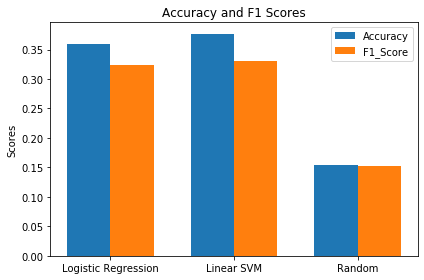

In [33]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1_Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()